In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import keras_tuner as kt

In [8]:
# Download crypto data
cryptos = ['BTC-USD', 'ETH-USD', 'USDT-USD', 'BNB-USD', 'SOL-USD', 'XRP-USD', 'DX-Y.NYB']
data = yf.download(cryptos, start='2020-10-01', end='2024-10-01')
price_df = data['Adj Close']
price_df

[*********************100%***********************]  7 of 7 completed


Ticker,BNB-USD,BTC-USD,DX-Y.NYB,ETH-USD,SOL-USD,USDT-USD,XRP-USD
Date,,,,,,,
2020-10-01 00:00:00+00:00,27.431973,10619.452148,93.709999,353.205902,2.861028,1.000699,0.238249
2020-10-02 00:00:00+00:00,27.285681,10575.974609,93.839996,346.238922,2.626083,1.001049,0.234117
2020-10-03 00:00:00+00:00,28.202311,10549.329102,NaN,346.522095,2.547303,1.001108,0.232938
2020-10-04 00:00:00+00:00,28.943853,10669.583008,NaN,352.579010,2.515995,1.001359,0.247685
2020-10-05 00:00:00+00:00,28.659103,10793.339844,93.510002,353.956787,2.657644,1.000866,0.250816
...,...,...,...,...,...,...,...
2024-09-26 00:00:00+00:00,596.776917,65181.019531,100.559998,2632.199951,155.576096,1.000243,0.590421
2024-09-27 00:00:00+00:00,607.867004,65790.664062,100.419998,2695.900635,157.749939,1.000179,0.588927
2024-09-28 00:00:00+00:00,601.567200,65887.648438,NaN,2677.539062,156.912430,1.000186,0.614801


Trial 3 Complete [00h 00m 09s]
val_loss: 0.003610149724408984

Best val_loss So Far: 0.003610149724408984
Total elapsed time: 00h 00m 19s


/Users/yb/anaconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 96)         │        37,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 96)             │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │         2,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,654 (447.87 KB)

 Trainable params: 114,654 (447.87 KB)

 Non-trainable params: 0 (0.00 B)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
DX-Y.NYB MSE: 0.00021


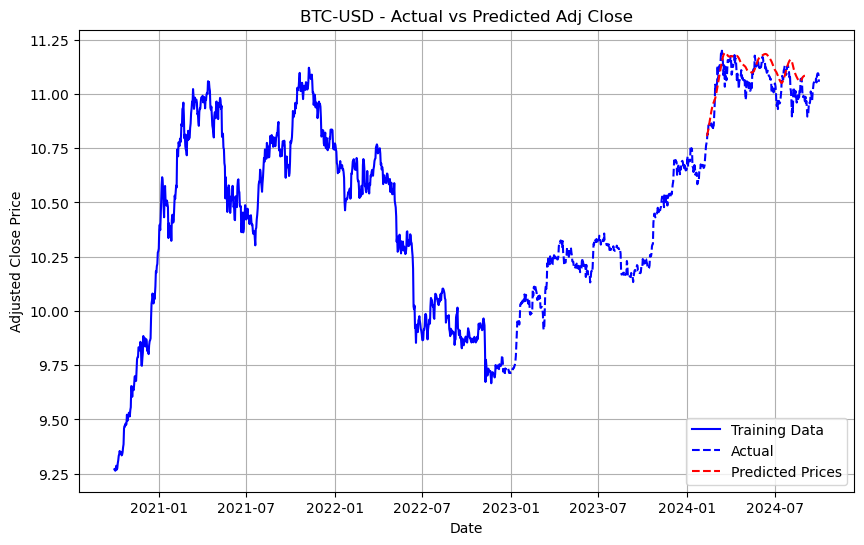

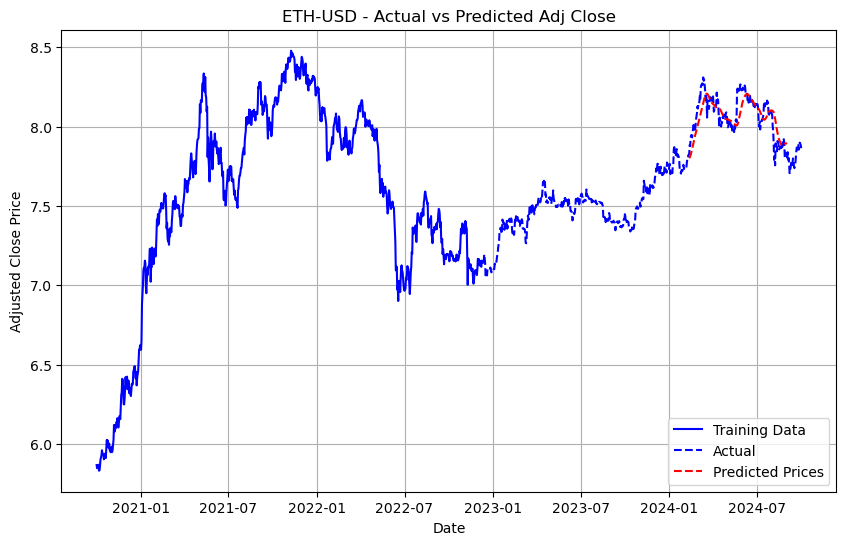

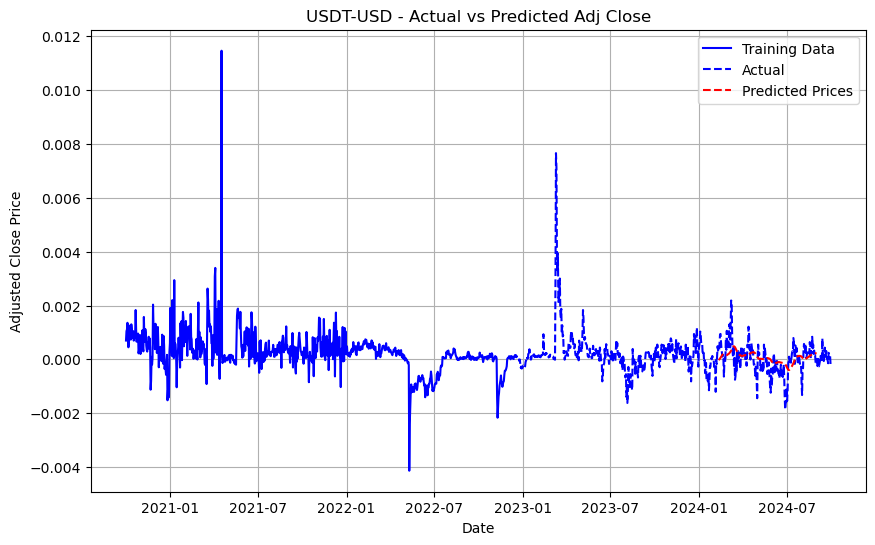

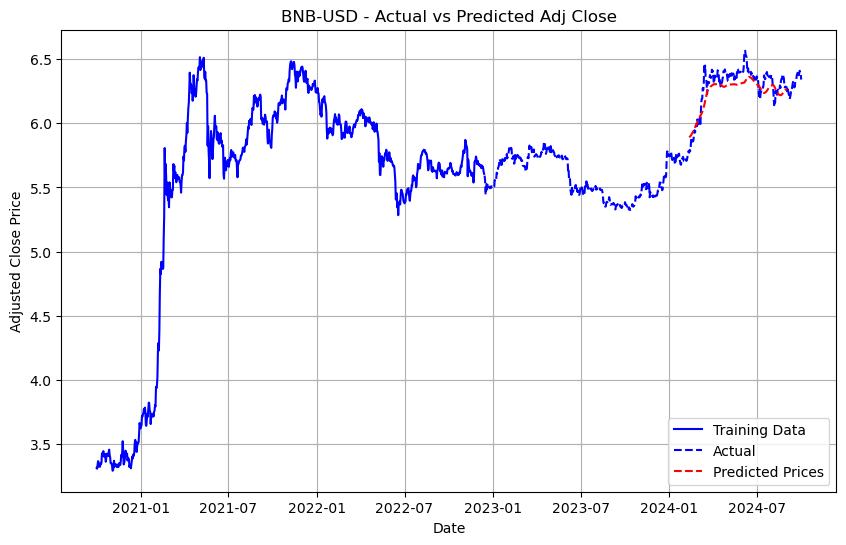

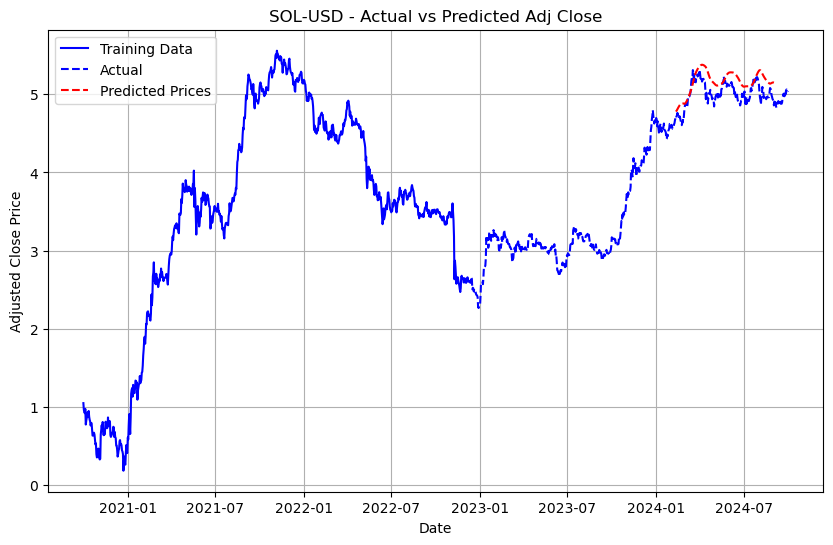

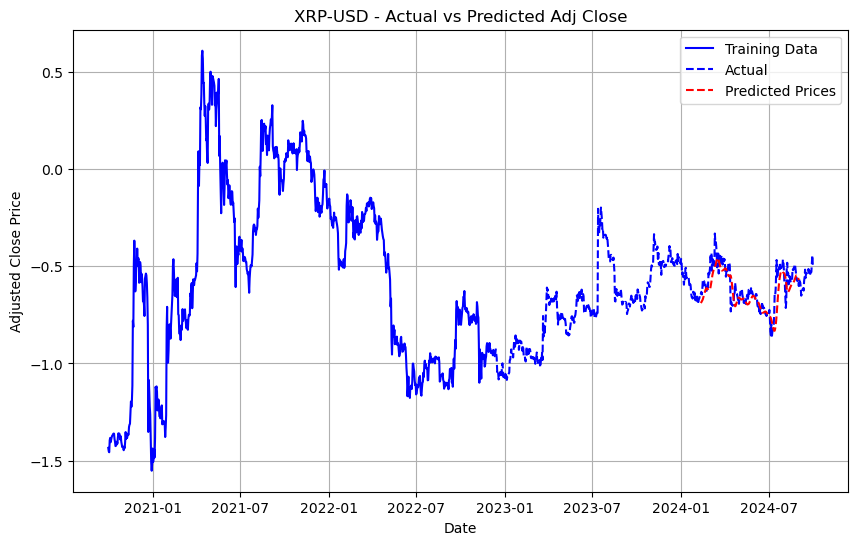

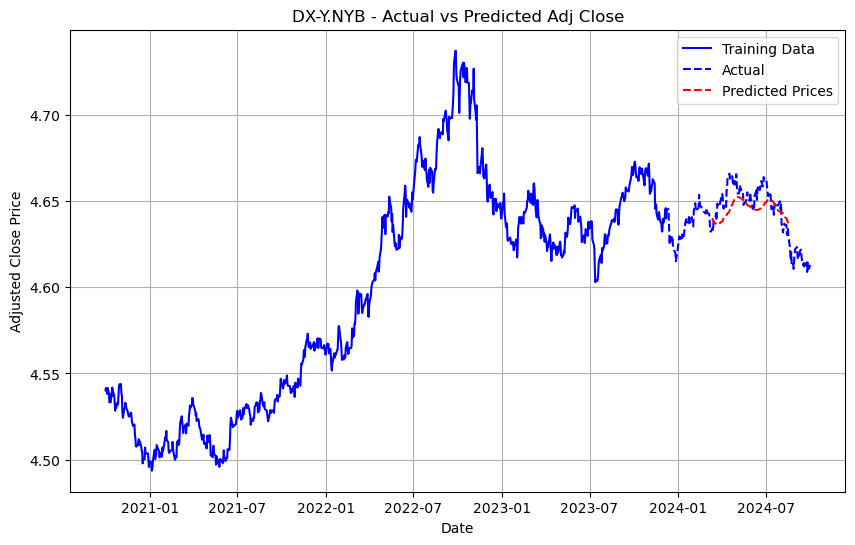

     Ticker           MSE
0   BTC-USD  1.130708e-02
1   ETH-USD  2.209116e-02
2  USDT-USD  3.079324e-07
3   BNB-USD  3.926081e-02
4   SOL-USD  3.748768e-02
5   XRP-USD  1.061087e-02
6  DX-Y.NYB  2.142207e-04


In [12]:
def create_sequences(data, n_steps, n_outputs):
    X, y = [], []
    for i in range(len(data) - n_steps - n_outputs + 1):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps:i + n_steps + n_outputs])
    return np.array(X), np.array(y)

# Function to build the LSTM model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   input_shape=(n_steps, 1), return_sequences=True))
    model.add(Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)))
    model.add(Dense(30))  # Predict 30 days ahead
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Store results to plot later
all_actuals = {}
all_predictions = {}
mse_results = {}

# Loop over each crypto ticker
for ticker in cryptos:
    print(f"Processing {ticker}...")

    # 1. Log Transformation
    log_transformed = np.log(price_df[ticker].dropna())

    # 2. Train-Test Split (80-20)
    train_size = int(len(log_transformed) * 0.8)
    train_data, test_data = log_transformed[:train_size], log_transformed[train_size:]

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.values.reshape(-1, 1))

    # Create sequences for LSTM
    n_steps = 60  # Use a 60-day window
    X_train, y_train = create_sequences(train_scaled, n_steps, 30)  # Predict 30 steps
    X_test, y_test = create_sequences(test_scaled, n_steps, 30)

    # 3. Hyperparameter Tuning with Keras Tuner
    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=3,
        executions_per_trial=1,
        directory='/tmp/' + ticker+'multi_step',
        project_name='crypto_lstm'
    )

    tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
    best_model = tuner.get_best_models(num_models=1)[0]
    best_model.summary()

    # 4. Prediction and storing results for later plotting
    y_pred = best_model.predict(X_test)

    # Reshape predictions and test data to match MinMaxScaler expectations
    y_pred_reshaped = y_pred.reshape(-1, 1)  # Shape (samples * 30, 1)
    y_test_reshaped = y_test.reshape(-1, 1)

    # Inverse transform predictions and test data
    y_pred_rescaled = scaler.inverse_transform(y_pred_reshaped).reshape(y_pred.shape)
    y_test_rescaled = scaler.inverse_transform(y_test_reshaped).reshape(y_test.shape)

    y_pred_rescaled_flat = y_pred_rescaled.reshape(-1, 30)  # Ensure shape is (num_samples, 30)
    y_test_rescaled_flat = y_test_rescaled.reshape(-1, 30)  # Ensure shape is (num_samples, 30)

    # Calculate MSE across all 30 steps
    mse = mean_squared_error(y_test_rescaled_flat, y_pred_rescaled_flat)
    mse_results[ticker] = mse
 
    print(f'{ticker} MSE: {mse:.5f}')

    # Store predictions and actual values for later plotting
    all_actuals[ticker] = log_transformed
    all_predictions[ticker] = (train_size + n_steps, y_pred_rescaled)

# 5. After gathering all data, plot the results for each ticker
for ticker in cryptos:
    actual = all_actuals[ticker]
    start_idx, predictions = all_predictions[ticker]

    # Flatten predictions for plotting (only the first prediction of each sequence for simplicity)
    predictions_flat = predictions[:, 0]

    # Create a DataFrame for plotting the predictions (align dates properly)
    forecast_test = pd.DataFrame(
        {'ds': actual.index[start_idx:start_idx + len(predictions_flat)], 'y': predictions_flat}
    )

    plt.figure(figsize=(10, 6))

    # Plot actual training data (blue line)
    plt.plot(actual.index[:train_size], actual[:train_size], label='Training Data', color='blue')

    # Plot actual test data (blue dashed line)
    plt.plot(actual.index[train_size:], actual[train_size:], label='Actual', color='blue', linestyle='--')

    # Plot predicted prices (red dashed line)
    plt.plot(forecast_test['ds'], forecast_test['y'], label='Predicted Prices', color='red', linestyle='--')

    # Add plot details
    plt.title(f'{ticker} - Actual vs Predicted Adj Close')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# 6. Create and display the MSE results table
mse_df = pd.DataFrame(list(mse_results.items()), columns=['Ticker', 'MSE'])
print(mse_df)


In [15]:
mse_df['rmse'] = np.sqrt(mse_df['MSE'])
print(mse_df)

     Ticker           MSE      rmse
0   BTC-USD  1.130708e-02  0.106335
1   ETH-USD  2.209116e-02  0.148631
2  USDT-USD  3.079324e-07  0.000555
3   BNB-USD  3.926081e-02  0.198143
4   SOL-USD  3.748768e-02  0.193617
5   XRP-USD  1.061087e-02  0.103009
6  DX-Y.NYB  2.142207e-04  0.014636
